In [1413]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer, OneHotEncoder, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA


In [1414]:
THRESHOLD = 0.5

SEED = 42
np.random.seed(SEED)

DATASET_ROOT = './'
DATASET_TRAIN_NAME = 'AVC_train.csv'
DATASET_TEST_NAME = 'AVC_test.csv'
DATASET_FULL_NAME = 'AVC_full.csv'

numeric_features = ['mean_blood_sugar_level', 'body_mass_indicator', 'years_old', 'analysis_results', 'biological_age_index']
categorial_features = ['cardiovascular_issues', 'job_category', 'sex', 'tobacco_usage', 'high_blood_pressure', 'married', 'living_area', 'chaotic_sleep']
target_feature = 'cerebrovascular_accident'

train_features = numeric_features + categorial_features
all_features = train_features + [target_feature]

In [1415]:
train_df = pd.read_csv(DATASET_ROOT + DATASET_TRAIN_NAME)
test_df = pd.read_csv(DATASET_ROOT + DATASET_TEST_NAME)
full_df = pd.read_csv(DATASET_ROOT + DATASET_FULL_NAME)

# Set type to category in order to perform imputation
for feature in categorial_features + [target_feature]:
	train_df[feature] = train_df[feature].astype('category')
	test_df[feature] = test_df[feature].astype('category')
	full_df[feature] = full_df[feature].astype('category')

In [1416]:
def info_numerical_feature_dataset(X, feature):
	print(f'Numeric feature: {feature}')
	info_df = pd.DataFrame.describe(X[feature])
	print(info_df)
	print('\n')
	
	X.boxplot(column=[feature])
	plt.show()
	print('\n')

def info_categorical_feature_dataset(X, feature):
	print(f'Categorial feature: {feature}')
	info_df = pd.DataFrame.describe(X[feature])
	print(f'count	{info_df["count"]}')

	unique_df = pd.DataFrame(X[feature].value_counts())
	print(f'unique	{unique_df.shape[0]}')
	print(unique_df)
	print('\n')

	series = pd.Series(X[feature].value_counts())
	
	X[feature].hist(width=0.1 * (series.shape[0] - 1))
	plt.show()

Numeric feature: mean_blood_sugar_level
count    5110.000000
mean      106.147677
std        45.283560
min        55.120000
25%        77.245000
50%        91.885000
75%       114.090000
max       271.740000
Name: mean_blood_sugar_level, dtype: float64




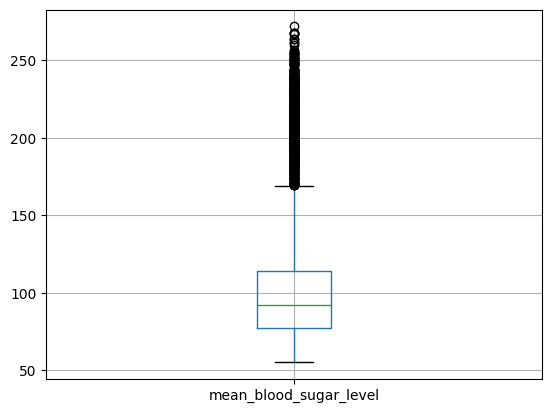



Numeric feature: body_mass_indicator
count    4909.000000
mean       28.893237
std         7.854067
min        10.300000
25%        23.500000
50%        28.100000
75%        33.100000
max        97.600000
Name: body_mass_indicator, dtype: float64




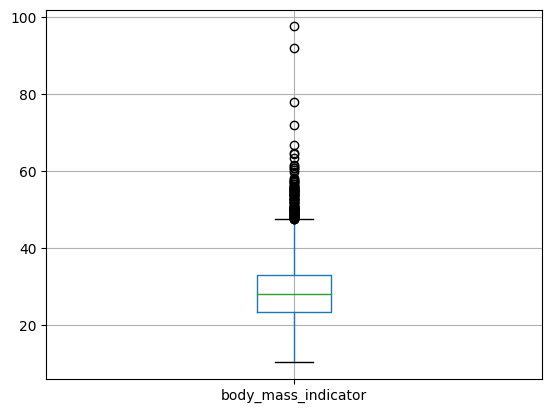



Numeric feature: years_old
count    5110.000000
mean       46.568665
std        26.593912
min         0.080000
25%        26.000000
50%        47.000000
75%        63.750000
max       134.000000
Name: years_old, dtype: float64




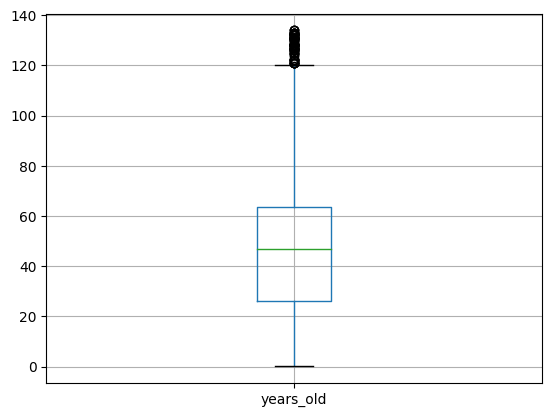



Numeric feature: analysis_results
count    4599.000000
mean      323.523446
std       101.577442
min       104.829714
25%       254.646209
50%       301.031628
75%       362.822769
max       756.807975
Name: analysis_results, dtype: float64




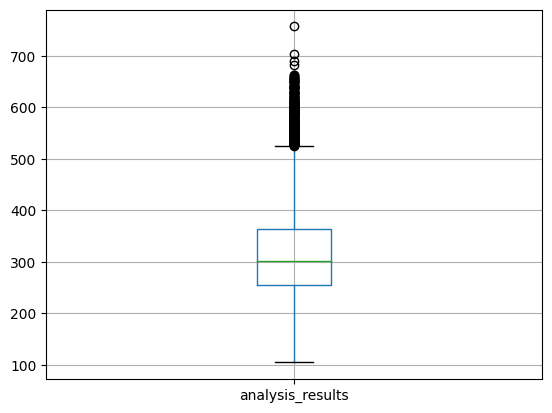



Numeric feature: biological_age_index
count    5110.000000
mean      134.784256
std        50.399352
min       -15.109456
25%        96.710581
50%       136.374631
75%       172.507322
max       266.986321
Name: biological_age_index, dtype: float64




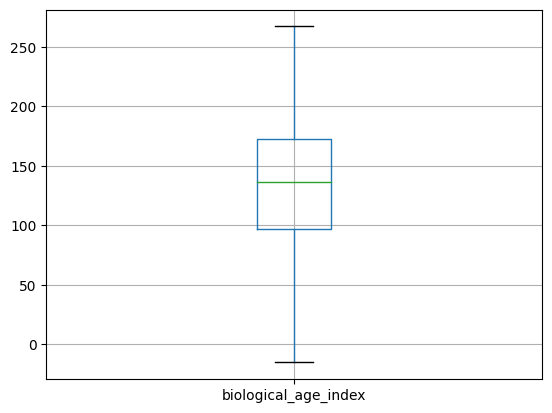



Categorial feature: cardiovascular_issues
count	5110
unique	2
                       count
cardiovascular_issues       
0                       4834
1                        276




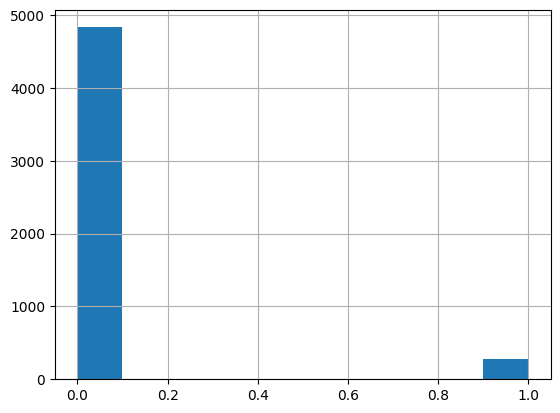

Categorial feature: job_category
count	5110
unique	5
                 count
job_category          
private_sector    2925
entrepreneurial    819
child              687
public_sector      657
N_work_history      22




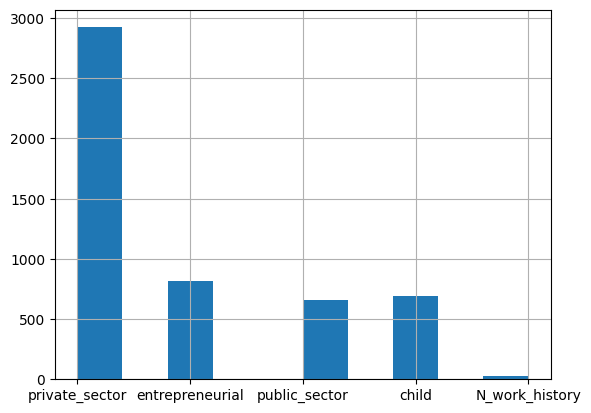

Categorial feature: sex
count	5110
unique	2
     count
sex       
F     2994
M     2116




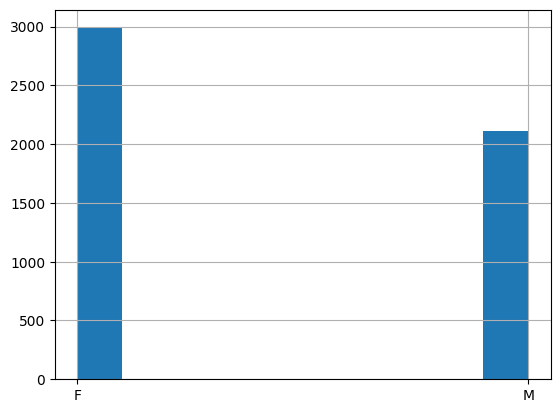

Categorial feature: tobacco_usage
count	5110
unique	4
               count
tobacco_usage       
non-smoker      1892
not_defined     1544
ex-smoker        885
smoker           789




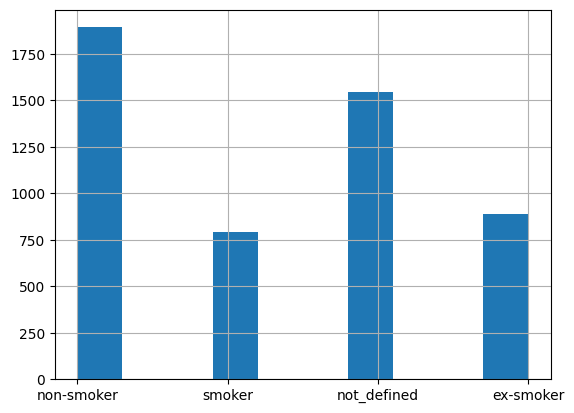

Categorial feature: high_blood_pressure
count	5110
unique	2
                     count
high_blood_pressure       
0                     4612
1                      498




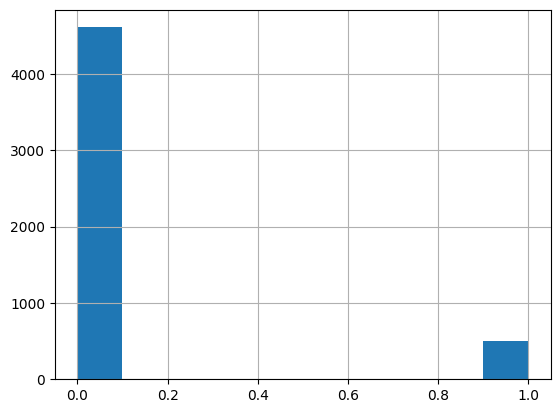

Categorial feature: married
count	4599
unique	2
         count
married       
Y         3014
N         1585




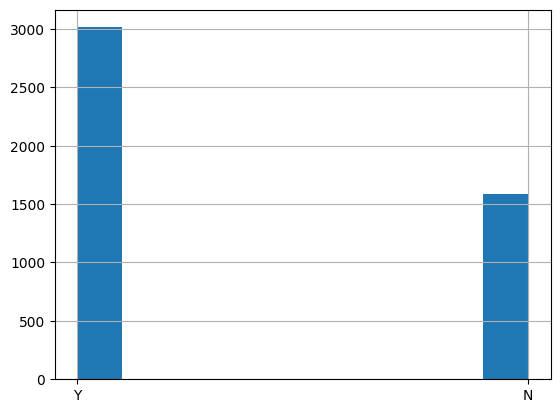

Categorial feature: living_area
count	5110
unique	2
             count
living_area       
City          2596
Countryside   2514




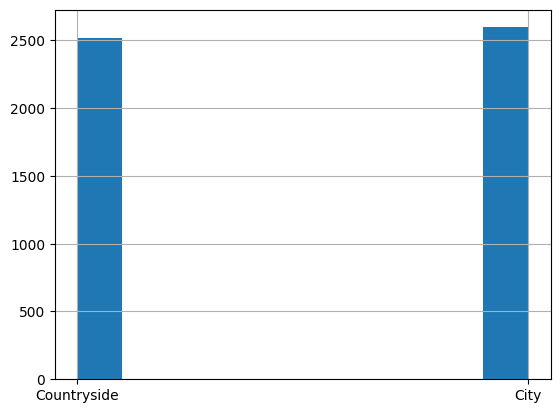

Categorial feature: chaotic_sleep
count	5110
unique	2
               count
chaotic_sleep       
0               4834
1                276




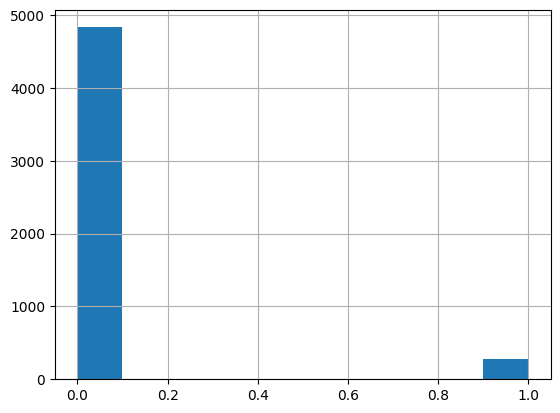

In [1417]:
for feature in numeric_features:
	info_numerical_feature_dataset(full_df, feature)

for feature in categorial_features:
	info_categorical_feature_dataset(full_df, feature)

In [1418]:
def visualize_class_distribution(X, dataset_name, feature):
	print(f'Dataset: {dataset_name}, Feature: {feature}')

	info = X[feature].value_counts()
	positive = info[1]
	negative = info[0]
	print(f'Positive: {positive}, Negative: {negative}')

	info.plot(kind='bar')
	plt.show()
	print('\n')

Dataset: Train, Feature: cerebrovascular_accident
Positive: 174, Negative: 3914


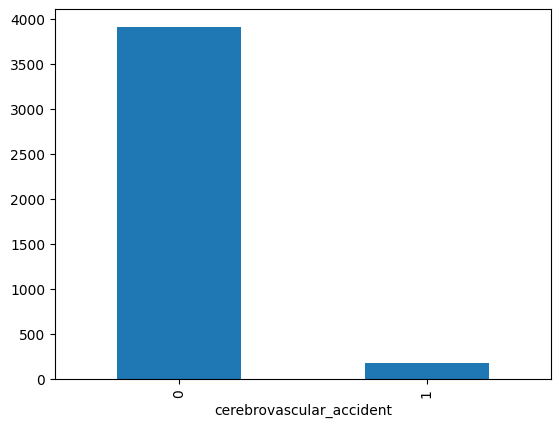



Dataset: Test, Feature: cerebrovascular_accident
Positive: 75, Negative: 947


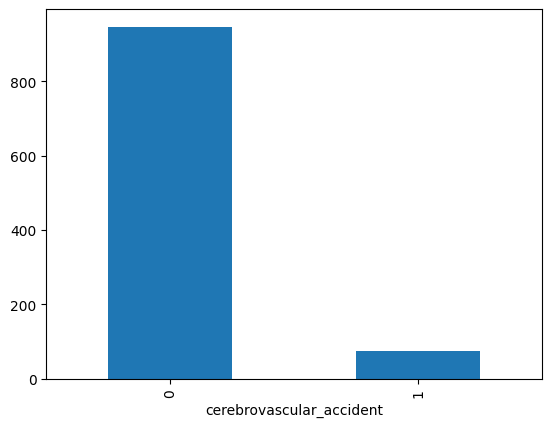



Dataset: Full, Feature: cerebrovascular_accident
Positive: 249, Negative: 4861


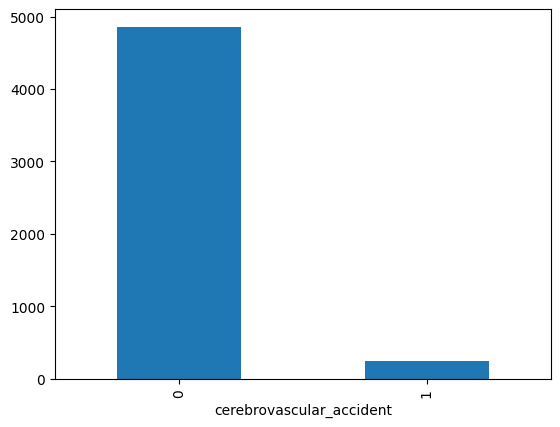

In [1419]:
visualize_class_distribution(train_df, 'Train', target_feature)
visualize_class_distribution(test_df, 'Test', target_feature)
visualize_class_distribution(full_df, 'Full', target_feature)

In [1420]:
def correlation_numerical_feature(X, features):
	print('Correlation numerical features')
	corr_df = pd.DataFrame(X[features])
	corr = corr_df.corr(method='pearson')
	print(corr)
	print('\n')

	fig = plt.figure(figsize=(14, 14))
	
	ax = fig.add_subplot(111)
	
	cax = ax.matshow(corr, vmin=0, vmax=1)
	
	fig.colorbar(cax)

	ticks = np.arange(0, len(corr_df.columns), 1)
	
	ax.set_xticks(ticks)
	ax.set_yticks(ticks)

	ax.set_xticklabels(corr_df.columns)
	ax.set_yticklabels(corr_df.columns)

	plt.title('Correlation Heatmap')
	plt.xlabel('Features')
	plt.ylabel('Features')

	plt.show()
	print('\n')

def correlation_categorical_feature(X, features):
	print('Correlation categorical features')

	corr_df = pd.DataFrame(X[features])
	corr = pd.DataFrame(columns=features, index=features)
	
	for feature1 in features:
		for feature2 in features:
			cross_tab = pd.crosstab(corr_df[feature1], corr_df[feature2])
			ChiSqResult = stats.chi2_contingency(cross_tab)
			corr.loc[feature1, feature2] = ChiSqResult[1]
	
	print(corr)
	print('\n')

	corr = corr.apply(pd.to_numeric)

	fig = plt.figure(figsize=(14, 14))
	
	ax = fig.add_subplot(111)
	
	cax = ax.matshow(corr, vmin=0, vmax=1)
	
	fig.colorbar(cax)

	ticks = np.arange(0, len(corr_df.columns), 1)
	
	ax.set_xticks(ticks)
	ax.set_yticks(ticks)

	ax.set_xticklabels(corr_df.columns)
	ax.set_yticklabels(corr_df.columns)

	plt.title('ChiSquared Correlation')
	plt.xlabel('Features')
	plt.ylabel('Features')

	plt.show()
	print('\n')

Correlation numerical features
                        mean_blood_sugar_level  body_mass_indicator  \
mean_blood_sugar_level                1.000000             0.175502   
body_mass_indicator                   0.175502             1.000000   
years_old                             0.193335             0.269022   
analysis_results                      0.894289             0.157301   
biological_age_index                  0.213950             0.291308   

                        years_old  analysis_results  biological_age_index  
mean_blood_sugar_level   0.193335          0.894289              0.213950  
body_mass_indicator      0.269022          0.157301              0.291308  
years_old                1.000000          0.189087              0.714135  
analysis_results         0.189087          1.000000              0.206042  
biological_age_index     0.714135          0.206042              1.000000  




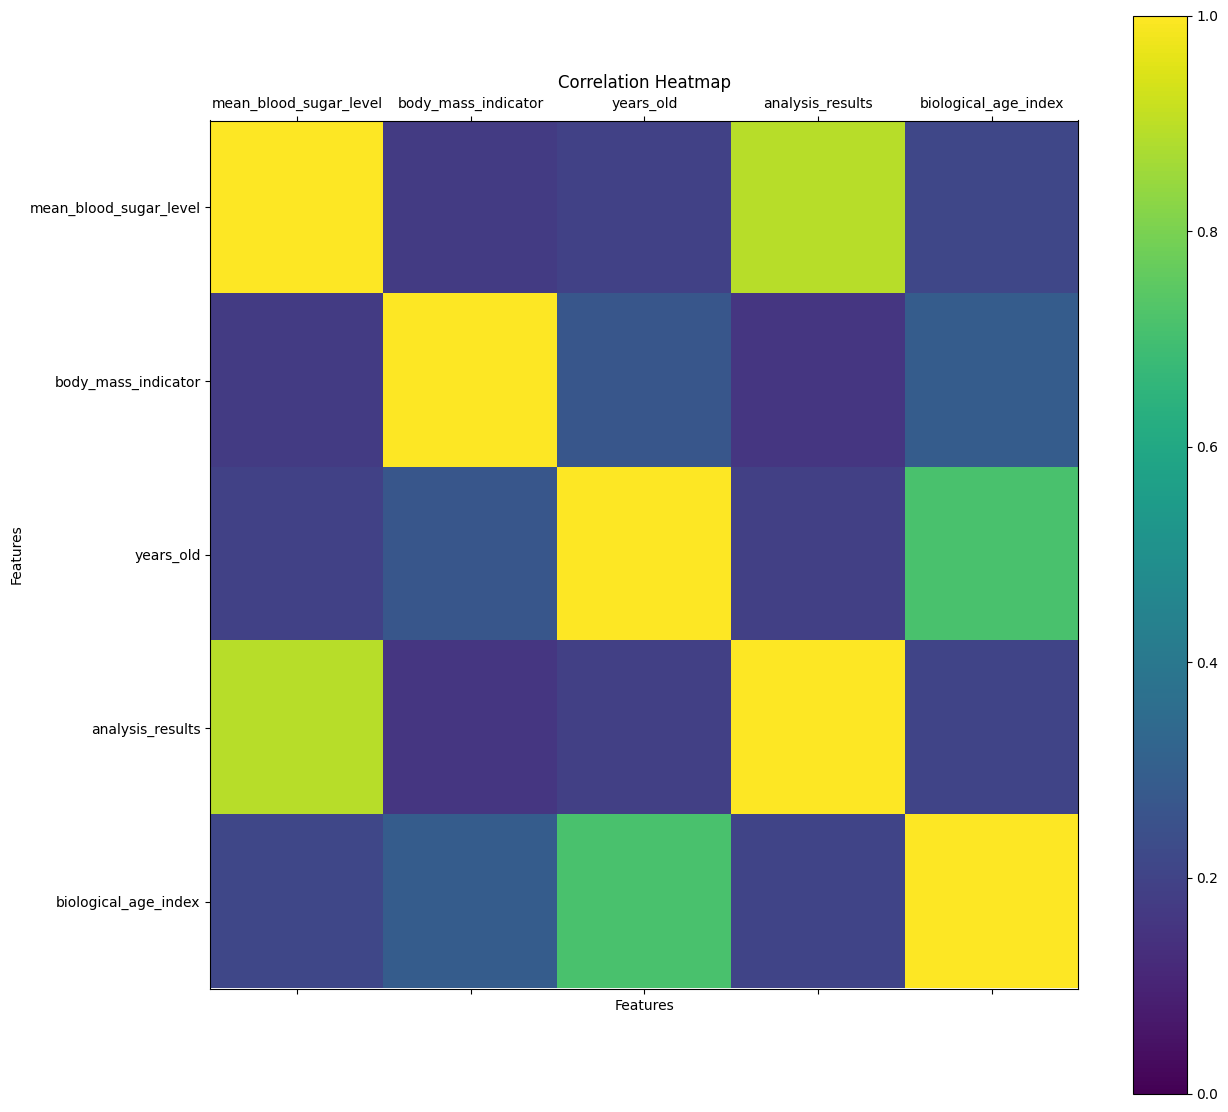



Correlation categorical features
                      cardiovascular_issues job_category       sex  \
cardiovascular_issues                   0.0          0.0       0.0   
job_category                            0.0          0.0       0.0   
sex                                     0.0          0.0       0.0   
tobacco_usage                           0.0          0.0       0.0   
high_blood_pressure                     0.0          0.0  0.143322   
married                                 0.0          0.0  0.089468   
living_area                        0.873562     0.324754  0.670986   
chaotic_sleep                           0.0          0.0       0.0   

                      tobacco_usage high_blood_pressure   married living_area  \
cardiovascular_issues           0.0                 0.0       0.0    0.873562   
job_category                    0.0                 0.0       0.0    0.324754   
sex                             0.0            0.143322  0.089468    0.670986   
tobacco_us

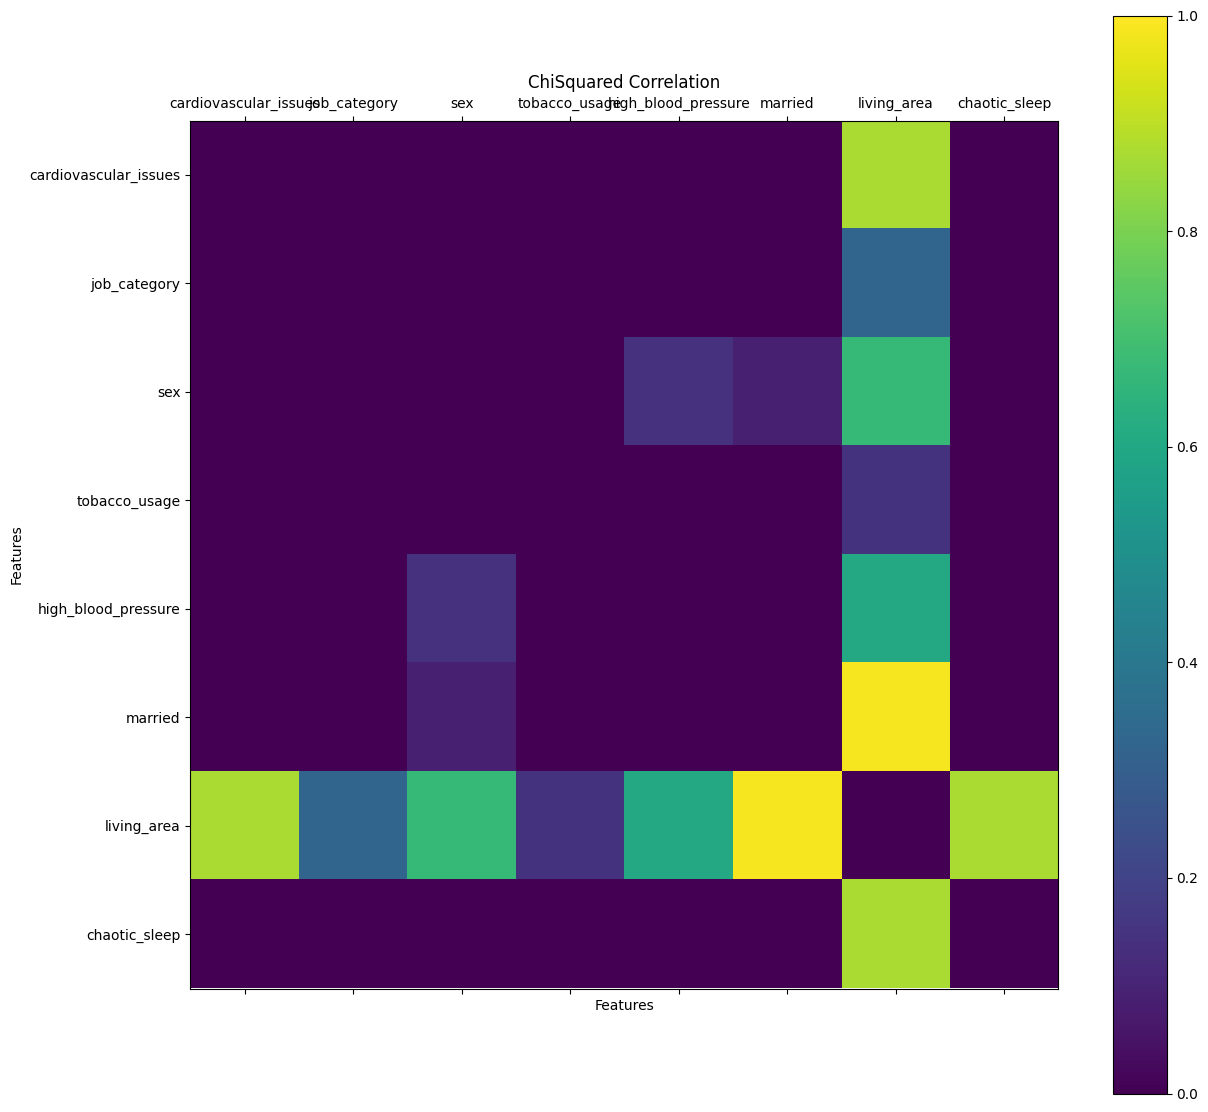

In [1421]:
correlation_numerical_feature(full_df, numeric_features)

correlation_categorical_feature(full_df, categorial_features)

In [1422]:
def eliminate_outliers(X, feature):
	print(f'Eliminate outliers for feature: {feature}')
	
	Q1 = X[feature].quantile(0.25)
	Q3 = X[feature].quantile(0.75)
	IQR = Q3 - Q1

	threshold = 1.5
	lower_bound = Q1 - threshold * IQR
	upper_bound = Q3 + threshold * IQR

	outliers = X[(X[feature] < lower_bound) | (X[feature] > upper_bound)]
	X.loc[outliers.index, feature] = np.nan

In [1423]:
def eliminate_hidden_missing_values(X, feature):
	print(f'Eliminate hidden missing values for feature: {feature}')
	
	hidden_missing_values = X[X[feature] == 'not_defined']
	X.loc[hidden_missing_values.index, feature] = np.nan

In [1424]:
for feature in numeric_features:
	eliminate_outliers(full_df, feature)

for feature in categorial_features:
	eliminate_hidden_missing_values(full_df, feature)

Eliminate outliers for feature: mean_blood_sugar_level
Eliminate outliers for feature: body_mass_indicator
Eliminate outliers for feature: years_old
Eliminate outliers for feature: analysis_results
Eliminate outliers for feature: biological_age_index
Eliminate hidden missing values for feature: cardiovascular_issues
Eliminate hidden missing values for feature: job_category
Eliminate hidden missing values for feature: sex
Eliminate hidden missing values for feature: tobacco_usage
Eliminate hidden missing values for feature: high_blood_pressure
Eliminate hidden missing values for feature: married
Eliminate hidden missing values for feature: living_area
Eliminate hidden missing values for feature: chaotic_sleep


In [1425]:
DROPPED_FEATURES = ['mean_blood_sugar_level', 'years_old', 'married', 'job_category', 'tobacco_usage', 'chaotic_sleep']

for feature in DROPPED_FEATURES:
	if feature in numeric_features:
		numeric_features.remove(feature)
	else:
		categorial_features.remove(feature)

full_df = full_df.drop(DROPPED_FEATURES, axis=1)

In [1426]:
def impute_missing_values_univariate(X, feature, missing_values, strategy):
	imputer = SimpleImputer(missing_values=missing_values, strategy=strategy)
	X[[feature]] = imputer.fit_transform(X[[feature]])

def impute_missing_values_multivariate(X, features, missing_value):
	imputer = IterativeImputer(max_iter=10, random_state=0, missing_values=missing_value)
	X[[features]] = imputer.fit_transform(X[[features]])

for feature in numeric_features:
	impute_missing_values_univariate(full_df, feature, np.nan, 'mean')

for feature in categorial_features:
	impute_missing_values_univariate(full_df, feature, np.nan, 'most_frequent')

In [1427]:
def scale_numerical_feature(X):
	scaler = StandardScaler().fit(X[numeric_features])
	X[numeric_features] = scaler.transform(X[numeric_features])

scale_numerical_feature(full_df)

In [1428]:
def split_dataset(dataset, split_index):
    X = dataset.drop(target_feature, axis=1)
    t = dataset[target_feature]

    X_train = X.iloc[:split_index]
    t_train = t.iloc[:split_index]

    X_test = X.iloc[split_index:]
    t_test = t.iloc[split_index:]

    encoder = OneHotEncoder()
    X_train_categorial = encoder.fit_transform(X_train[categorial_features])
    X_test_categorial = encoder.transform(X_test[categorial_features])

    X_train = np.concatenate((X_train[numeric_features].values, X_train_categorial.toarray()), axis=1)
    X_test = np.concatenate((X_test[numeric_features].values, X_test_categorial.toarray()), axis=1)

    label_encoder = LabelEncoder()
    t_train = label_encoder.fit_transform(t_train)
    t_test = label_encoder.transform(t_test)

    return X_train, t_train, X_test, t_test

def balance_dataset(X, t):
    positive_indices = np.where(t == 1)[0]
    negative_indices = np.where(t == 0)[0]

    positive_count = len(positive_indices)
    negative_count = len(negative_indices)

    negative_count = round(negative_count * 0.2)
    positive_count = round(positive_count * 0.9)

    positive_indices = np.random.choice(positive_indices, positive_count, replace=False)
    negative_indices = np.random.choice(negative_indices, negative_count, replace=False)

    indices = np.concatenate((positive_indices, negative_indices))
    np.random.shuffle(indices)

    # factor = negative_count // positive_count

    # new_X = np.concatenate(X, [X[positive_indices]] * factor, axis=0)
    # new_t = np.concatenate(t, [t[positive_indices]] * factor, axis=0)

    return X[indices], t[indices]

In [1429]:
X_train, t_train, X_test, t_test = split_dataset(full_df, len(train_df))
X_train, t_train = balance_dataset(X_train, t_train)

In [1430]:
# Sigmoid function
def logistic(x):
    return 1 / (1 + np.exp(-x))

In [1431]:
# Negative Log Likelihood
def nll(Y, T):
    N = T.shape[0]
    
    return -np.sum(T * np.log(Y) + (1 - T) * np.log(1 - Y)) / N

In [1432]:
# Determine accuracy of the logistic regression model
def accuracy(Y, T):
    N = Y.shape[0]

    return np.sum(T == (Y >= THRESHOLD)) / N

In [1433]:
def predict_logistic(X, w):
    N = X.shape[0]
    y = logistic(np.dot(X, w))
    return y

In [1434]:
def train_logistic(X_train, T_train, lr=.01, l2_value=.01, epochs_no=100):
    # Initialize weights
    N, D = X_train.shape
    w = np.random.randn(D)

    # Train the model
    for _ in range(epochs_no):
        Y_train = predict_logistic(X_train, w)
        w -= lr * (np.dot(X_train.T, Y_train - T_train) + l2_value * w) 

    return w

In [1435]:
N_EPOCHS = 500
w = train_logistic(X_train, t_train, lr=0.001, l2_value=0.01, epochs_no=N_EPOCHS)
Y_train1, Y_test1 = predict_logistic(X_train, w), predict_logistic(X_test, w)

Y_train1 = Y_train1 >= THRESHOLD
Y_test1 = Y_test1 >= THRESHOLD

In [1436]:
def precision(y_pred: pd.Series, y_true: pd.Series, c: str) -> float:
    pred_c = y_pred[y_pred == c]
    
    true_c = y_true[(y_pred == c) & (y_true == c)]
    
    if len(pred_c) == 0:
        return 0
    else:
        return len(true_c) / len(pred_c)
    
def recall(y_pred: pd.Series, y_true: pd.Series, c: str) -> float:
    true_c = y_true[y_true == c]
    
    pred_c = y_pred[(y_pred == c) & (y_true == c)]
    
    if len(true_c) == 0:
        return 0
    else:
        return len(pred_c) / len(true_c)
    
def f1_score(y_pred: pd.Series, y_true: pd.Series, c: str) -> float:
    p = precision(y_pred, y_true, c)
    r = recall(y_pred, y_true, c)
    
    if p + r == 0:
        return 0
    else:
        return 2 * p * r / (p + r)
    
def accuracy(y_pred: pd.Series, y_true: pd.Series) -> float:
    return (y_pred == y_true).sum() / len(y_true)

def evaluate(y: pd.Series, y_pred: pd.Series):
    from sklearn.metrics import classification_report

    print(classification_report(y, y_pred, zero_division=0))

def plot_confusion_matrix(y_pred: pd.Series, y_true: pd.Series):
    confusion_matrix = pd.crosstab(y_true, y_pred, rownames=['Actual'], colnames=['Predicted'], dropna=False)

    all_classes = np.unique(list(y_true) + list(y_pred))
    confusion_matrix = confusion_matrix.reindex(index=all_classes, columns=all_classes, fill_value=0)

    print(confusion_matrix)
    
    plt.figure(figsize=(10,7))
    sns.heatmap(confusion_matrix, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()

Statistics for train dataset - lab implementation of logistic regression
              precision    recall  f1-score   support

           0       0.85      0.97      0.91       783
           1       0.54      0.18      0.27       157

    accuracy                           0.84       940
   macro avg       0.70      0.57      0.59       940
weighted avg       0.80      0.84      0.80       940

Predicted    0   1
Actual            
0          759  24
1          129  28


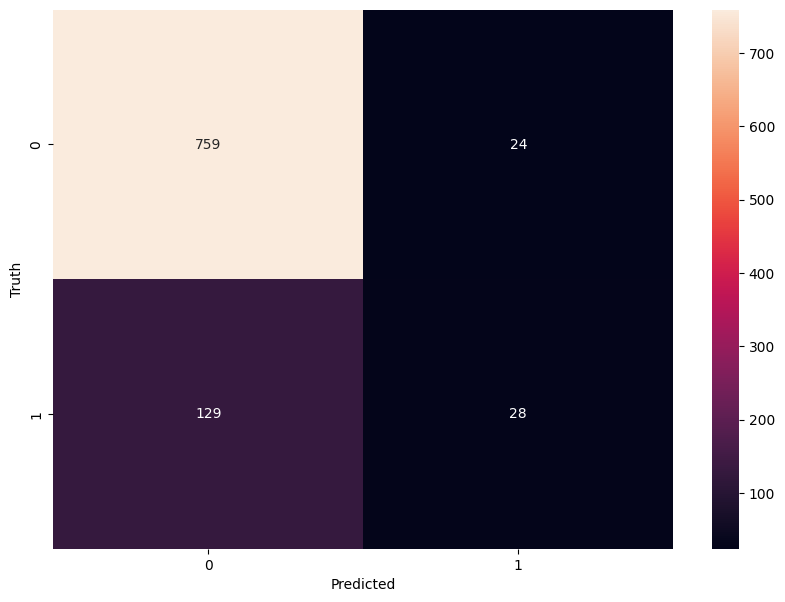

Statistics for test dataset - lab implementation of logistic regression
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       947
           1       0.33      0.21      0.26        75

    accuracy                           0.91      1022
   macro avg       0.63      0.59      0.61      1022
weighted avg       0.89      0.91      0.90      1022

Predicted    0   1
Actual            
0          914  33
1           59  16


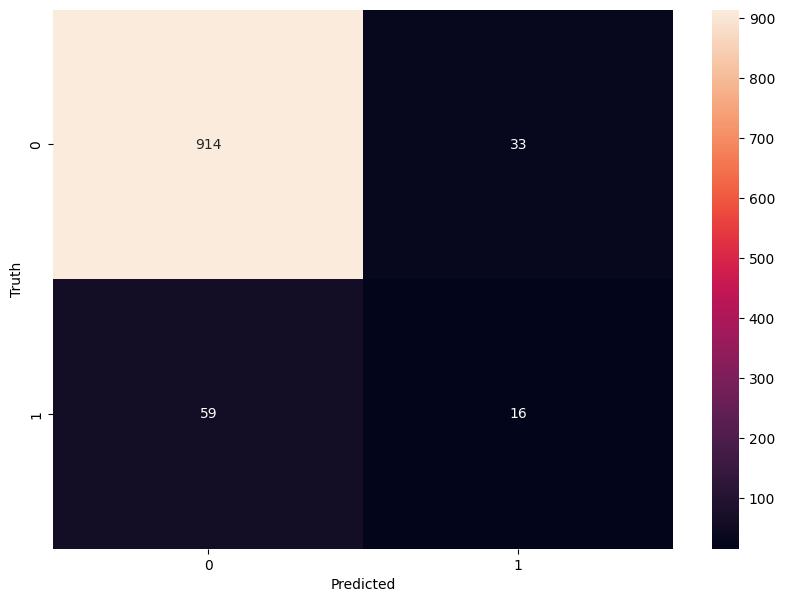

In [1437]:
print('Statistics for train dataset - lab implementation of logistic regression')
evaluate(t_train, Y_train1)
plot_confusion_matrix(Y_train1, t_train)

print('Statistics for test dataset - lab implementation of logistic regression')
evaluate(t_test, Y_test1)
plot_confusion_matrix(Y_test1, t_test)

In [1438]:
class_weights = {0: 1, 1: 1}
clf = LogisticRegression(solver='liblinear', penalty='l2', class_weight=class_weights, random_state=SEED, max_iter=N_EPOCHS).fit(X_train, t_train)

Y_train2 = clf.predict(X_train)
Y_test2 = clf.predict(X_test)

clf.score(X_train, t_train)
clf.score(X_test, t_test)

0.9099804305283757

Statistics for train dataset - library logistic regression
              precision    recall  f1-score   support

           0       0.85      0.97      0.91       783
           1       0.52      0.17      0.25       157

    accuracy                           0.84       940
   macro avg       0.69      0.57      0.58       940
weighted avg       0.80      0.84      0.80       940

Predicted    0   1
Actual            
0          759  24
1          131  26


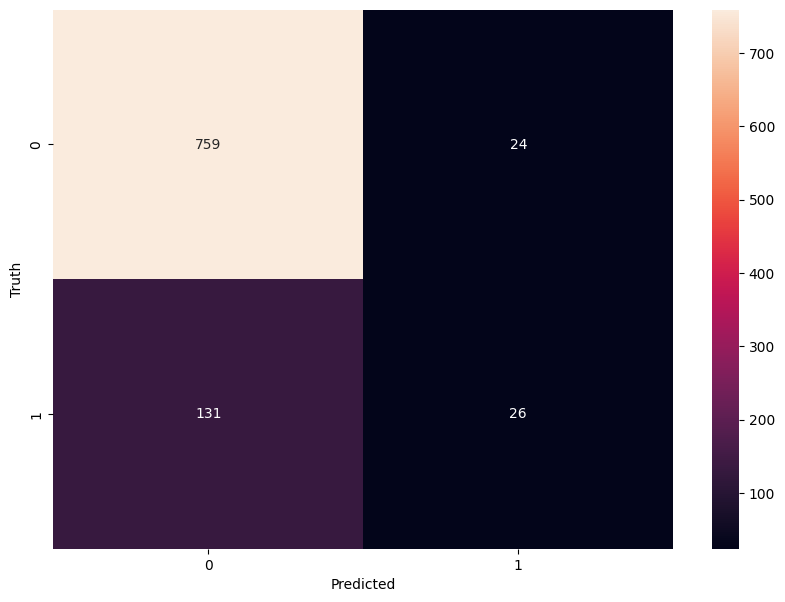

Statistics for test dataset - library logistic regression
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       947
           1       0.33      0.21      0.26        75

    accuracy                           0.91      1022
   macro avg       0.63      0.59      0.61      1022
weighted avg       0.89      0.91      0.90      1022

Predicted    0   1
Actual            
0          914  33
1           59  16


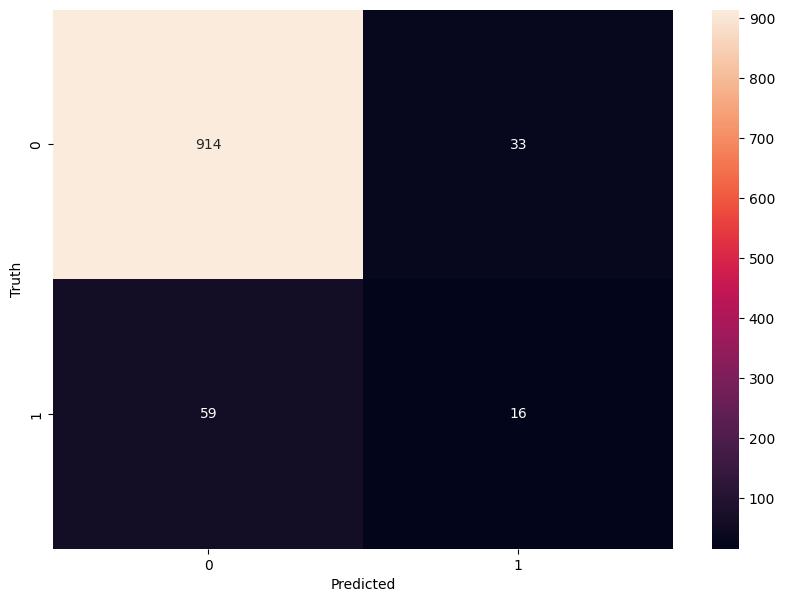

In [1439]:
print('Statistics for train dataset - library logistic regression')
evaluate(t_train, Y_train2)
plot_confusion_matrix(Y_train2, t_train)

print('Statistics for test dataset - library logistic regression')
evaluate(t_test, Y_test2)
plot_confusion_matrix(Y_test2, t_test)

In [1440]:
class Layer:

    def forward(self, x: np.ndarray) -> np.ndarray:
        raise NotImplementedError
        
    def backward(self, x: np.ndarray, dy: np.ndarray) -> np.ndarray:
        raise NotImplementedError
        
    def update(self, *args, **kwargs):
        pass  # If a layer has no parameters, then this function does nothing

In [1441]:
class FeedForwardNetwork:
    
    def __init__(self, layers):
        self.layers = layers
        
    def forward(self, x: np.ndarray, train: bool = True) -> np.ndarray:
        self._inputs = []
        for layer in self.layers:
            if train:
                self._inputs.append(x)
            x = layer.forward(x)
        return x
    
    def backward(self, dy: np.ndarray) -> np.ndarray:
        reverse_layers = reversed(self.layers)
        for layer in reverse_layers:
            dy = layer.backward(self._inputs.pop(), dy)    
        
        del self._inputs
        return dy

    def update(self, *args, **kwargs):
        for layer in self.layers:
            layer.update(*args, **kwargs)

In [1442]:
class Linear(Layer):
    
    def __init__(self, insize: int, outsize: int) -> None:
        bound = np.sqrt(6. / insize)
        self.weight = np.random.uniform(-bound, bound, (insize, outsize))
        self.bias = np.zeros((outsize,))
        
        self.dweight = np.zeros_like(self.weight)
        self.dbias = np.zeros_like(self.bias)
   
    def forward(self, x: np.ndarray) -> np.ndarray:
        y = np.dot(x, self.weight) + self.bias
        return y
    
    def backward(self, x: np.ndarray, dy: np.ndarray) -> np.ndarray:
        self.dweight = np.dot(x.T, dy)
        self.dbias = np.sum(dy, axis=0)
        dx = np.dot(dy, self.weight.T)
        return dx

    def update(self, mode='SGD', lr=0.001, mu=0.9):
        if mode == 'SGD':
            self.weight -= lr * self.dweight
            self.bias -= lr * self.dbias
        else:
            raise ValueError('mode should be SGD, not ' + str(mode))

In [1443]:
class ReLU(Layer):
    
    def __init__(self) -> None:
        pass
    
    def forward(self, x: np.ndarray) -> np.ndarray:
        y = np.maximum(0, x)
        return y
    
    def backward(self, x: np.ndarray, dy: np.ndarray) -> np.ndarray:
        dx = dy * np.where(x > 0, 1, 0)
        return dx

In [1444]:
class CrossEntropy:
    
    def __init__(self):
        pass
    
    def softmax(self, x):
        exps = np.exp(x)
        return exps / np.sum(exps,axis = 1).reshape(-1,1)

    def forward(self, y: np.ndarray, t: np.ndarray) -> float:
        y = self.softmax(y)
        loss = -np.log(y[np.arange(len(t)), t])
        return np.mean(loss)

    def backward(self, y: np.ndarray, t: np.ndarray) -> np.ndarray:
        new_y = self.softmax(y)
        new_y[np.arange(len(t)), t] -= 1
        return new_y / len(t)

In [1445]:
def accuracy(y: np.ndarray, t: np.ndarray) -> float:
    y = np.argmax(y, axis=1)
    return np.sum(y == t) / len(t)

In [1446]:
BATCH_SIZE = 32
HIDDEN_UNITS = 300
EPOCHS_NO = 20

optimize_args = {'mode': 'SGD', 'lr': .001}

net = FeedForwardNetwork([Linear(11, HIDDEN_UNITS),
                          ReLU(),
                          Linear(HIDDEN_UNITS, 2)])
cost_function = CrossEntropy()

train_acc_mlp = []
test_acc_mlp = []

train_nll_mlp = []
test_nll_mlp = []

for epoch in range(EPOCHS_NO):
    for b_no, idx in enumerate(range(0, len(X_train), BATCH_SIZE)):
        # 1. Pregatim urmatorul batch
        x = X_train[idx:idx + BATCH_SIZE]
        t = t_train[idx:idx + BATCH_SIZE]

        y = net.forward(x)
        loss = cost_function.forward(y, t)
        dy = cost_function.backward(y, t)
        net.backward(dy)

        # 3. Actualizam parametrii retelei
        net.update(**optimize_args)
        
        print(f'\rEpoch {epoch + 1:02d} '
              f'| Batch {b_no:03d} '
              f'| Train NLL: {loss:6.3f} '
              f'| Train Acc: {accuracy(y, t) * 100:6.2f}% ', end='')

    y = net.forward(X_test, train=False)
    test_nll = cost_function.forward(y, t_test)
    
    train_acc_mlp.append(accuracy(net.forward(X_train), t_train))
    test_acc_mlp.append(accuracy(y, t_test))

    train_nll_mlp.append(cost_function.forward(net.forward(X_train), t_train))
    test_nll_mlp.append(test_nll)

    print(f'| Test NLL: {test_nll:6.3f} '
          f'| Test Acc: {accuracy(y, t_test) * 100:3.2f}%')


Epoch 01 | Batch 029 | Train NLL:  0.661 | Train Acc:  66.67% | Test NLL:  0.486 | Test Acc: 78.28%
Epoch 02 | Batch 029 | Train NLL:  0.538 | Train Acc:  75.00% | Test NLL:  0.341 | Test Acc: 91.19%
Epoch 03 | Batch 029 | Train NLL:  0.509 | Train Acc:  75.00% | Test NLL:  0.303 | Test Acc: 91.88%
Epoch 04 | Batch 029 | Train NLL:  0.494 | Train Acc:  75.00% | Test NLL:  0.286 | Test Acc: 92.07%
Epoch 05 | Batch 029 | Train NLL:  0.483 | Train Acc:  75.00% | Test NLL:  0.277 | Test Acc: 92.07%
Epoch 06 | Batch 029 | Train NLL:  0.474 | Train Acc:  75.00% | Test NLL:  0.272 | Test Acc: 91.88%
Epoch 07 | Batch 029 | Train NLL:  0.467 | Train Acc:  75.00% | Test NLL:  0.268 | Test Acc: 91.98%
Epoch 08 | Batch 029 | Train NLL:  0.461 | Train Acc:  75.00% | Test NLL:  0.265 | Test Acc: 91.98%
Epoch 09 | Batch 029 | Train NLL:  0.456 | Train Acc:  75.00% | Test NLL:  0.262 | Test Acc: 91.78%
Epoch 10 | Batch 029 | Train NLL:  0.451 | Train Acc:  75.00% | Test NLL:  0.260 | Test Acc: 91.88%


Statistics for train dataset - lab implementation MLP
              precision    recall  f1-score   support

           0       0.84      0.97      0.90       783
           1       0.42      0.11      0.17       157

    accuracy                           0.83       940
   macro avg       0.63      0.54      0.54       940
weighted avg       0.77      0.83      0.78       940

Predicted    0   1
Actual            
0          760  23
1          140  17


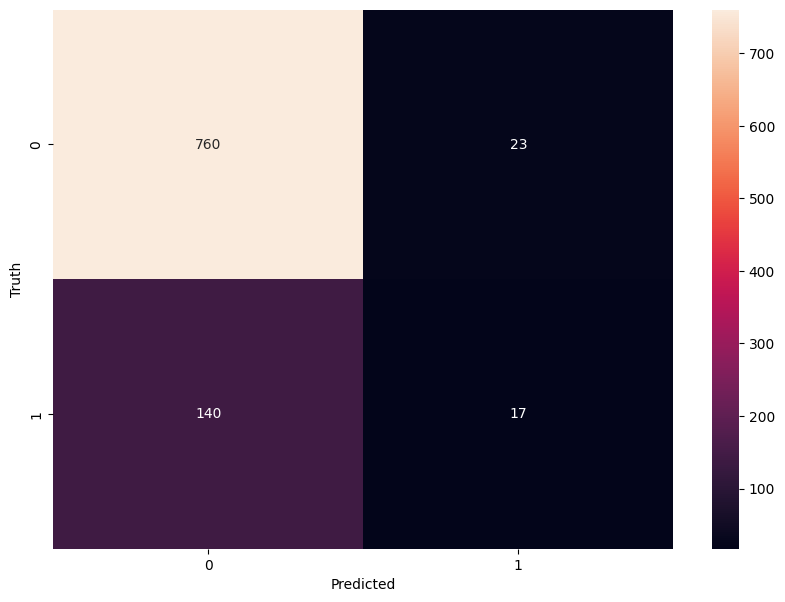

Statistics for test dataset - lab implementation MLP
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       947
           1       0.32      0.16      0.21        75

    accuracy                           0.91      1022
   macro avg       0.63      0.57      0.58      1022
weighted avg       0.89      0.91      0.90      1022

Predicted    0   1
Actual            
0          922  25
1           63  12


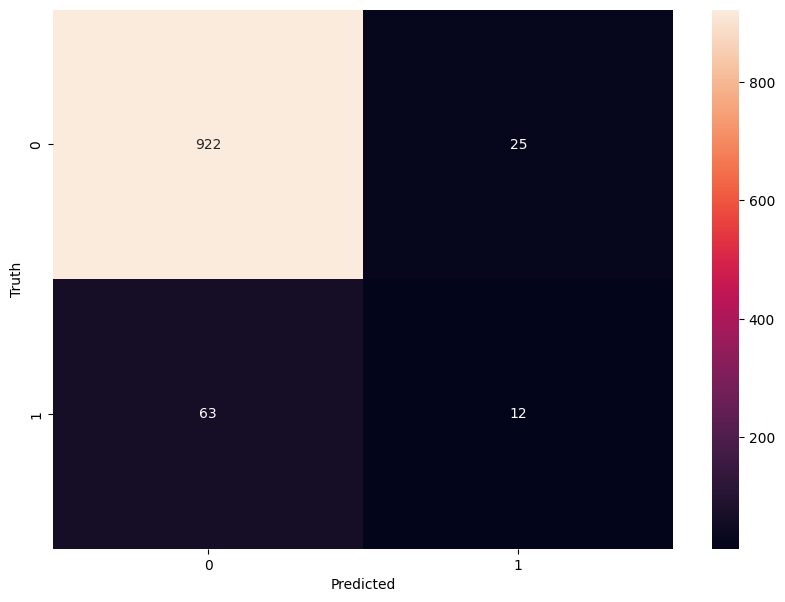

In [1447]:
Y_train3 = net.forward(X_train, train=False)
Y_train3 = np.argmax(Y_train3, axis=1)

print('Statistics for train dataset - lab implementation MLP')
evaluate(t_train, Y_train3)
plot_confusion_matrix(Y_train3, t_train)

Y_test3 = net.forward(X_test, train=False)
Y_test3 = np.argmax(Y_test3, axis=1)

print('Statistics for test dataset - lab implementation MLP')
evaluate(t_test, Y_test3)
plot_confusion_matrix(Y_test3, t_test)

In [1448]:
def plot_evolution(train_acc, test_acc, train_nll, test_nll):
    epochs_no = len(train_acc)
    _, (ax1, ax2) = plt.subplots(2,1)

    # Afisam cu verde acuratetea pe setul de antrenare si cu rosu acuratetea pe setul de testare
    ax1.plot(range(epochs_no), train_acc, label="Train Accuracy", color="green")
    ax1.plot(range(epochs_no), test_acc, label="Test Accuracy", color="red")
    ax1.set_ylabel("Accuracy")
    ax1.legend(loc='lower right', ncol=1)

    # Afisam cu verde NLL pe setul de antrenare si cu rosu NLL pe setul de testare
    ax2.plot(range(epochs_no), train_nll, label="Train NLL", color="green")
    ax2.plot(range(epochs_no), test_nll, label="Test NLL", color="red")
    ax2.set_xlabel("iteration")
    ax2.set_ylabel("NLL")
    ax2.legend(loc='upper right', ncol=1)
    
    plt.show()

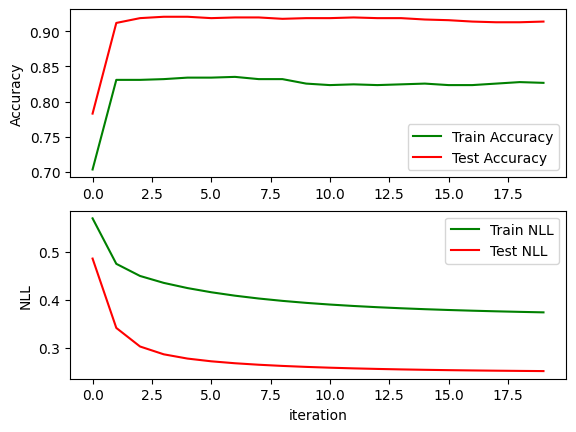

In [1449]:
plot_evolution(train_acc_mlp, test_acc_mlp, train_nll_mlp, test_nll_mlp)

Statistics for train dataset - library MLP classifier
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       783
           1       0.75      0.32      0.45       157

    accuracy                           0.87       940
   macro avg       0.81      0.65      0.69       940
weighted avg       0.86      0.87      0.85       940

Predicted    0   1
Actual            
0          766  17
1          106  51


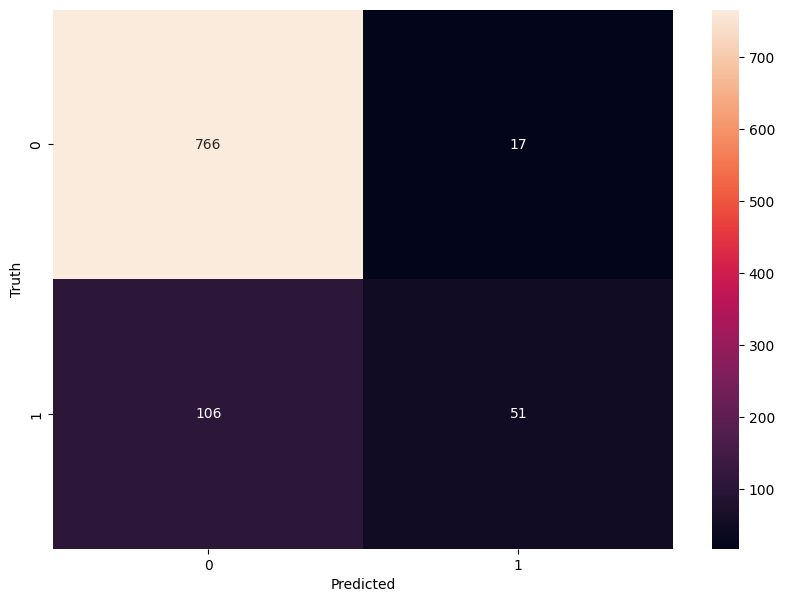

Statistics for test dataset - library MLP classifier
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       947
           1       0.20      0.15      0.17        75

    accuracy                           0.89      1022
   macro avg       0.57      0.55      0.56      1022
weighted avg       0.88      0.89      0.89      1022

Predicted    0   1
Actual            
0          903  44
1           64  11


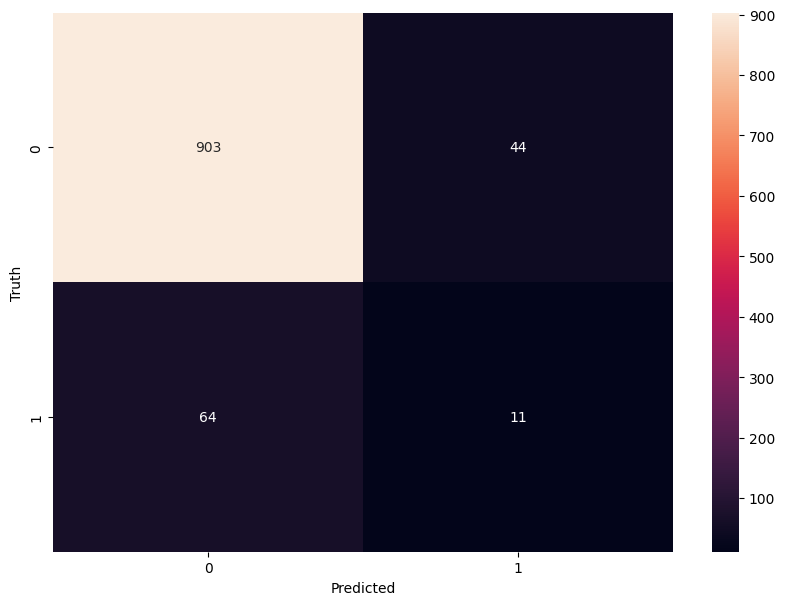

In [1450]:
clf = MLPClassifier(solver='adam', activation='relu', batch_size=32, random_state=1, max_iter=N_EPOCHS, alpha=0.05, learning_rate='adaptive', learning_rate_init=0.001).fit(X_train, t_train)

Y_train4 = clf.predict(X_train)
Y_test4 = clf.predict(X_test)

clf.score(X_train, t_train)
clf.score(X_test, t_test)

print('Statistics for train dataset - library MLP classifier')
evaluate(t_train, Y_train4)
plot_confusion_matrix(Y_train4, t_train)

print('Statistics for test dataset - library MLP classifier')
evaluate(t_test, Y_test4)
plot_confusion_matrix(Y_test4, t_test)